In [46]:
import importlib
import train
import models

importlib.reload(train)
importlib.reload(models)

from train import download_data, train, test
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch
import random
from models import Linear,ResidualBlock,MultiLayerNet



In [18]:
full_train_ds, full_test_ds = download_data()
data_loader = DataLoader(full_test_ds, batch_size=64, shuffle=True)

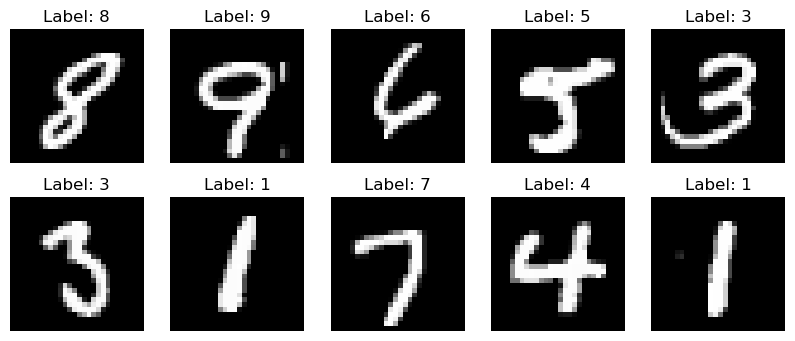

In [19]:
images, labels = next(iter(data_loader))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = Linear(28 * 28, 10).to(device)
train(model)
test(model)

Epoch 1/5, Training Loss: 1.7142
Validation Loss: 0.0252
Epoch 2/5, Training Loss: 1.5915
Validation Loss: 0.0247
Epoch 3/5, Training Loss: 1.5730
Validation Loss: 0.0245
Epoch 4/5, Training Loss: 1.5635
Validation Loss: 0.0244
Epoch 5/5, Training Loss: 1.5573
Validation Loss: 0.0243
Test Accuracy: 0.9249, 9249/10000


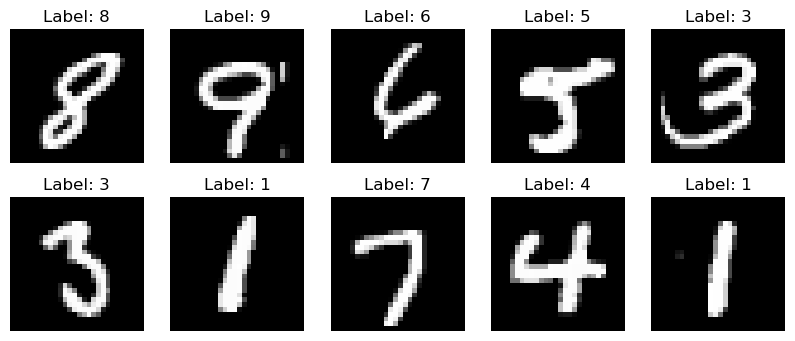

In [25]:
data_loader = DataLoader(full_test_ds, batch_size=64, shuffle=True)
images, labels = next(iter(data_loader))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

images = images.view(images.size(0), -1)
output = model(images)
output = output.argmax(dim=1, keepdim=True)
# output

In [43]:
model = ResidualBlock(28 * 28, 10, 0.3).to(device)
train(model)
test(model)

tensor(1.0962, grad_fn=<MaxBackward1>) tensor(-0.2458, grad_fn=<MinBackward1>)
tensor(0.9025, grad_fn=<MaxBackward1>) tensor(-0.2494, grad_fn=<MinBackward1>)
tensor(1.1040, grad_fn=<MaxBackward1>) tensor(-0.2499, grad_fn=<MinBackward1>)
tensor(1.3390, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(1.1841, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(1.1628, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(1.5618, grad_fn=<MaxBackward1>) tensor(-0.2498, grad_fn=<MinBackward1>)
tensor(1.6757, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(2.3734, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(2.2216, grad_fn=<MaxBackward1>) tensor(-0.2499, grad_fn=<MinBackward1>)
tensor(3.1833, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(3.1510, grad_fn=<MaxBackward1>) tensor(-0.2500, grad_fn=<MinBackward1>)
tensor(3.7598, grad_fn=<MaxBackward1>) tensor(-0.250

In [51]:
model = MultiLayerNet(28 * 28, 10, 200).to(device)
train(model)
test(model)

Epoch 1/5, Training Loss: 1.6299
Validation Loss: 0.0240
Epoch 2/5, Training Loss: 1.5225
Validation Loss: 0.0237
Epoch 3/5, Training Loss: 1.5071
Validation Loss: 0.0235
Epoch 4/5, Training Loss: 1.4986
Validation Loss: 0.0235
Epoch 5/5, Training Loss: 1.4924
Validation Loss: 0.0234
Test Accuracy: 0.9682, 9682/10000
